In [89]:
# *----------------------------------*
#           BASIC LIBRARIES
# *----------------------------------*

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from sklearn import decomposition

In [90]:
# *------------------------------------------------------*
#                       READING DATA
# *------------------------------------------------------*
onlyfiles = ['../data/' + f for f in listdir('../data/') if isfile(join('../data/', f))]
print(onlyfiles)

def treatement(file, limit=-1):
    file = open(file, encoding='iso-8859-1')
    data = file.read()
    file.close()
    data = data.replace('\n', ' ')
    if limit != -1:
        data = np.array(data.split(' name '))[:-limit]
    else:
        data = np.array(data.split(' name '))
    data = list(filter(lambda x: len(x) > 0, list(map(lambda x: np.array(x.split(' ')).flatten(), data))))[:-1]
    data = np.float32(np.array(data))
    condlist = [2, 3, 8, 9, 11, 13, 14, 15, 18, 31, 32, 33, 34, 37, 39, 40, 43, 50, 57]
    data_selected = []
    for i in range(len(data)):
        data_selected.append([data[i][x] for x in range(len(data[i])) if x in condlist])
    data_selected = np.array(data_selected)
    return data_selected


data = []
for file in onlyfiles:
    if 'cleveland' in file:
        data = data + list(treatement(file, 11))
    else:
        data = data + list(treatement(file))


data = np.array(data)


['../data/cleveland.data', '../data/hungarian.data', '../data/long-beach-va.data', '../data/new.data', '../data/preprocess.csv', '../data/switzerland.data']


In [91]:
df = pd.DataFrame(data, columns=['age', 'sex', 'chest_pain', 'presure_blood_resting', 
                                          'colesterol','cigarettes_per_day', 'smoker_years',
                                           'sugar', 'electrocardio',
                                          'max_heart_rate',  'res_heart_rate',
                                          'blood_presure_sistoles', 'blood_presure_diastoles', 
                                          'angina', 'rest_after_exercicie_presure',
                                          'slope_of_rest_after_exercise', 'major_vessels', 'thal',
                                          'prob'])

In [92]:
# *------------------------------------------------------*
#       NAN DEFINED VALUES AND INCHORENENT VALUES
# *------------------------------------------------------*
df[df == -9.0] = np.nan
df[df['presure_blood_resting'] == 0] = np.nan
df[df['colesterol'] == 0] = np.nan

In [93]:
# *------------------------------------------------------*
#               FIRST VIEW OF DATA VALUES
# *------------------------------------------------------*

for name in df.columns:
    print('\033[1m'+name+'\033[0;0m')
    print(df[name].unique())


age
[63. 67. 37. 41. 56. 62. 57. 53. 44. 52. 48. 54. 49. 64. 58. 60. 50. 66.
 43. 40. 69. 59. 42. 55. 61. 65. 71. 51. 46. 45. 39. 68. 47. 34. 35. 29.
 70. 77. 38. 74. 76. 36. 32. 31. 33. 28. 30. nan 72. 75.]
sex
[ 1.  0. nan]
chest_pain
[ 1.  4.  3.  2. nan]
presure_blood_resting
[145. 160. 120. 130. 140. 172. 150. 110. 132. 117. 135. 112. 105. 124.
 125. 142. 128. 170. 155. 104. 180. 138. 108. 134. 122. 115. 118. 100.
 200.  94. 165. 102. 152. 101. 126. 174. 148. 178. 158. 192. 129. 144.
 123. 136. 146. 106. 156. 154. 113. 190.  92.  98.  nan  96. 116. 114.
 127. 164.]
colesterol
[233. 286. 229. 250. 204. 236. 268. 354. 254. 203. 192. 294. 256. 263.
 199. 168. 239. 275. 266. 211. 283. 284. 224. 206. 219. 340. 226. 247.
 167. 230. 335. 234. 177. 276. 353. 243. 225. 302. 212. 330. 175. 417.
 197. 198. 290. 253. 172. 273. 213. 305. 216. 304. 188. 282. 185. 232.
 326. 231. 269. 267. 248. 360. 258. 308. 245. 270. 208. 264. 321. 274.
 325. 235. 257. 164. 141. 252. 255. 201. 222. 260. 182. 3

In [94]:
# *------------------------------------------------------*
#               REMOVING OUTLIERS
# *------------------------------------------------------*

col =['colesterol', 'cigarettes_per_day', 'max_heart_rate', 'presure_blood_resting', 
     'blood_presure_diastoles', 'blood_presure_sistoles', 'res_heart_rate']
for name in col:
    df = df[~(np.abs(df[name] - df[name].mean()) > 3*df[name].std())]

In [95]:
# *------------------------------------------------------*
#                   TOTAL NUMBER OF NULLS
# *------------------------------------------------------*

print("Total of nulls", df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100, "%")
print(df.columns)

Total of nulls 23.992209439260805 %
Index(['age', 'sex', 'chest_pain', 'presure_blood_resting', 'colesterol',
       'cigarettes_per_day', 'smoker_years', 'sugar', 'electrocardio',
       'max_heart_rate', 'res_heart_rate', 'blood_presure_sistoles',
       'blood_presure_diastoles', 'angina', 'rest_after_exercicie_presure',
       'slope_of_rest_after_exercise', 'major_vessels', 'thal', 'prob'],
      dtype='object')


In [96]:
# *------------------------------------------------------*
#                   CHANGING DATATYPE
# *------------------------------------------------------*

bool_columns = ['angina', 'sugar']
for name in bool_columns:
    df.loc[df[name].notna(), name] = df[df[name].notna()][name].astype(int)

df.loc[:,'angina'] = df['angina'].apply(lambda x: x > 0)
df.loc[:,'sugar'] = df['sugar'].apply(lambda x: x > 0)
df.loc[:,'sex'] = df['sex'].apply(lambda x: x > 0)

In [97]:
# *------------------------------------------------------*
#                   ERROR VALUES
# *------------------------------------------------------*

df['thal'].replace(1.0, np.nan, inplace=True)
df['thal'].replace(5.0, np.nan, inplace=True)

df['prob'].replace(0.2, np.nan, inplace=True)

df['slope_of_rest_after_exercise'].replace(0.0, np.nan, inplace=True)
df['major_vessels'].replace(9.0, np.nan, inplace=True)


In [98]:
# *------------------------------------------------------*
#               ONE HOT ENCODING FOR CATEGORIACAL
# *------------------------------------------------------*

categoric_columns = ["thal", "slope_of_rest_after_exercise", "major_vessels", "electrocardio", "chest_pain"]
for name in categoric_columns:
    OneHot = pd.get_dummies(df[name], prefix=name)
    df = df.join(OneHot)
    del df[name]

In [99]:
df.columns

Index(['age', 'sex', 'presure_blood_resting', 'colesterol',
       'cigarettes_per_day', 'smoker_years', 'sugar', 'max_heart_rate',
       'res_heart_rate', 'blood_presure_sistoles', 'blood_presure_diastoles',
       'angina', 'rest_after_exercicie_presure', 'prob', 'thal_3.0',
       'thal_6.0', 'thal_7.0', 'slope_of_rest_after_exercise_1.0',
       'slope_of_rest_after_exercise_2.0', 'slope_of_rest_after_exercise_3.0',
       'major_vessels_0.0', 'major_vessels_1.0', 'major_vessels_2.0',
       'major_vessels_3.0', 'electrocardio_0.0', 'electrocardio_1.0',
       'electrocardio_2.0', 'chest_pain_1.0', 'chest_pain_2.0',
       'chest_pain_3.0', 'chest_pain_4.0'],
      dtype='object')

In [100]:
# *------------------------------------------------------*
#           NORMALIZING AND IMPUTING MISSING VALUES
# *------------------------------------------------------*

min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df.values)
df2 = pd.DataFrame(df_scaled)
imputer = KNNImputer()
df2[:]= imputer.fit_transform(df2)
df2 = pd.DataFrame(min_max_scaler.inverse_transform(df2), columns=['age', 'sex', 'presure_blood_resting', 'colesterol',
       'cigarettes_per_day', 'smoker_years', 'sugar', 'max_heart_rate',
       'res_heart_rate', 'blood_presure_sistoles', 'blood_presure_diastoles',
       'angina', 'rest_after_exercicie_presure', 'prob', 'thal_3.0',
       'thal_6.0', 'thal_7.0', 'slope_of_rest_after_exercise_1.0',
       'slope_of_rest_after_exercise_2.0', 'slope_of_rest_after_exercise_3.0',
       'major_vessels_0.0', 'major_vessels_1.0', 'major_vessels_2.0',
       'major_vessels_3.0', 'electrocardio_0.0', 'electrocardio_1.0',
       'electrocardio_2.0', 'chest_pain_1.0', 'chest_pain_2.0',
       'chest_pain_3.0', 'chest_pain_4.0'])

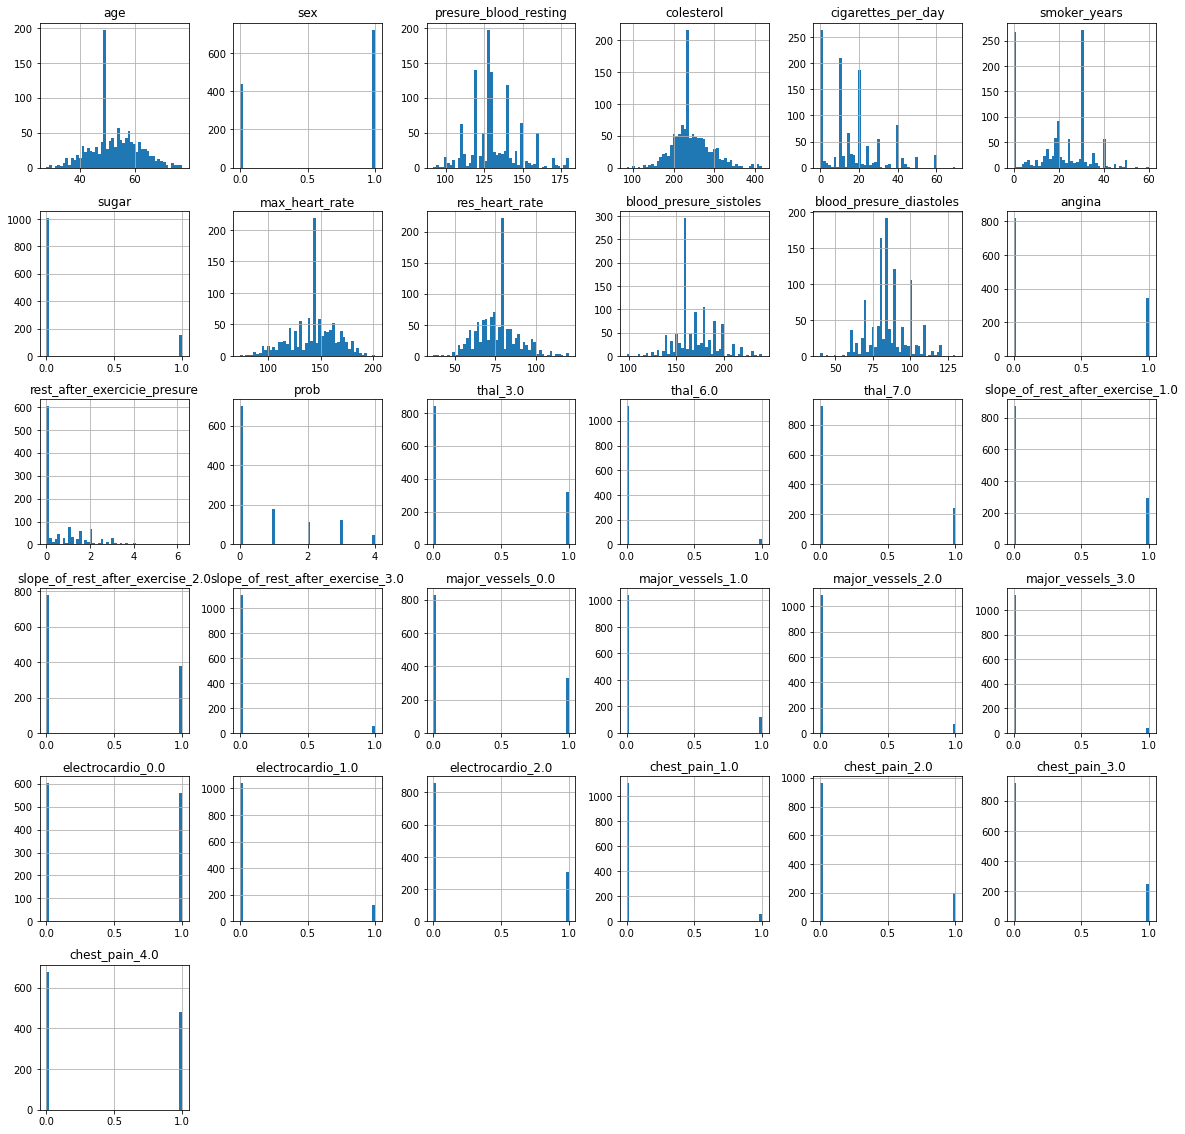

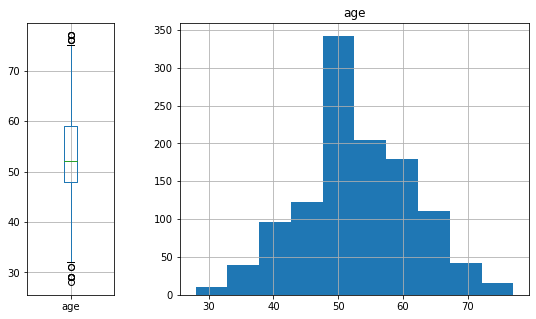

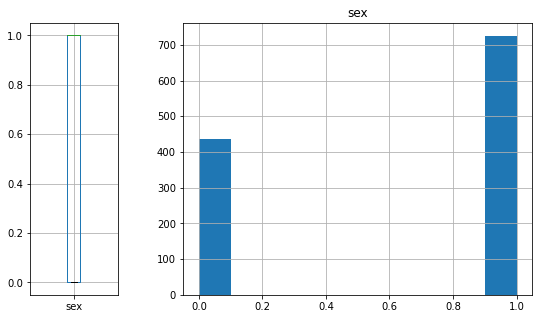

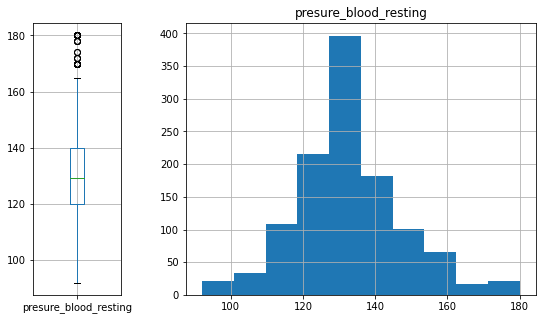

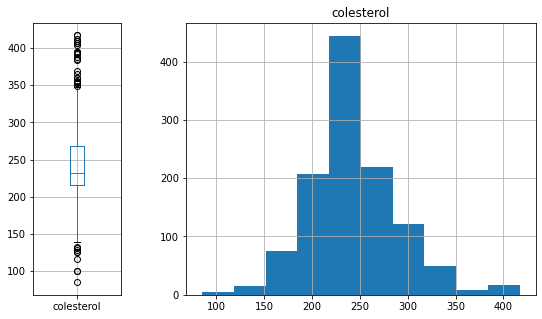

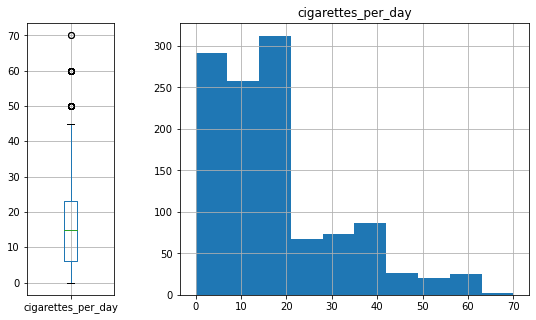

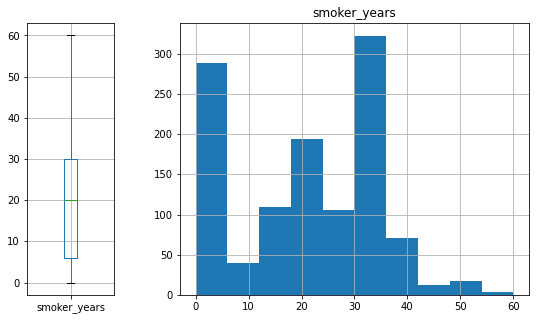

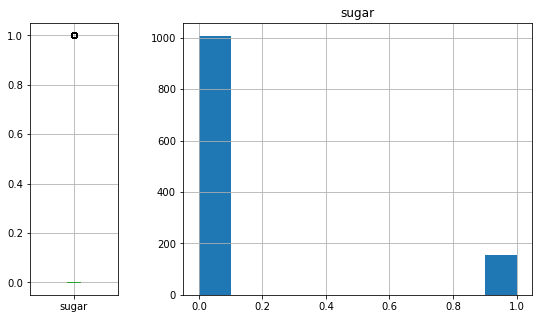

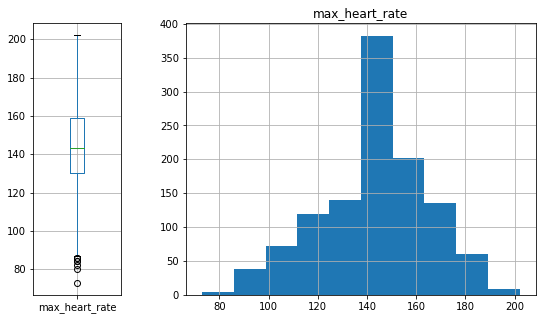

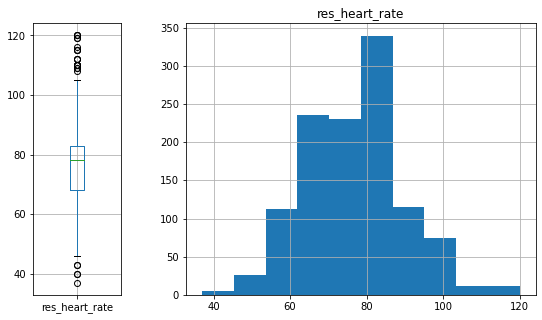

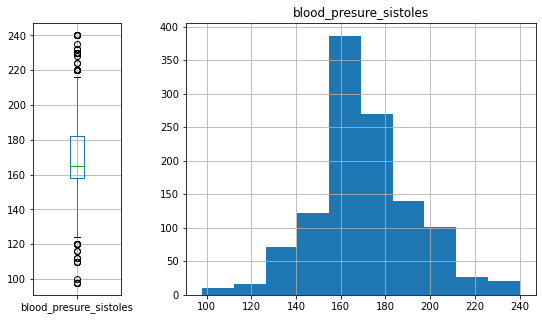

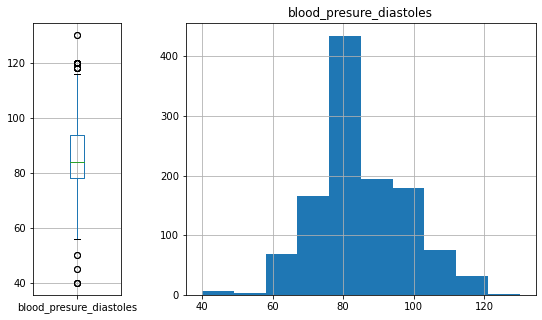

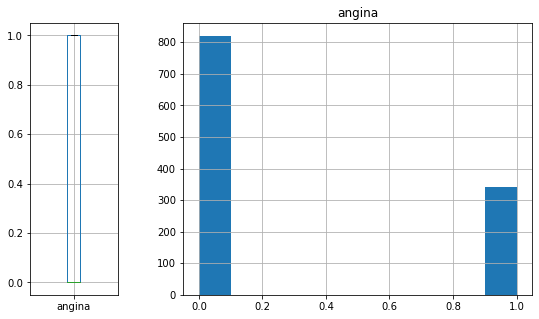

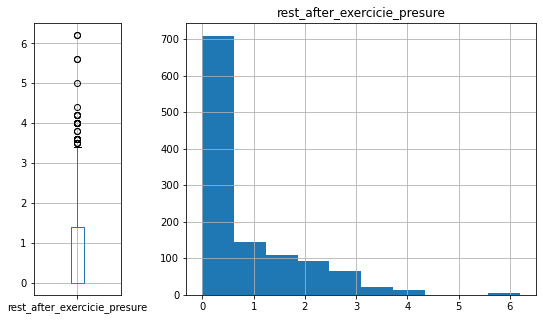

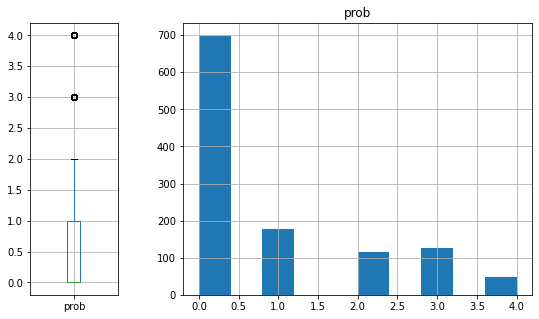

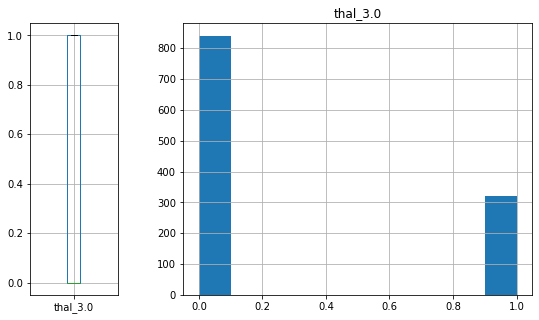

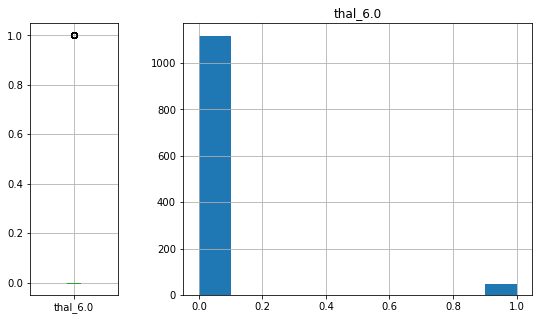

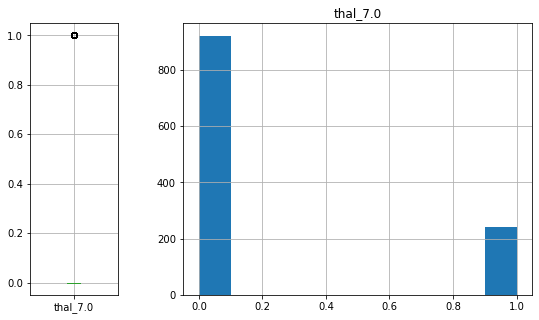

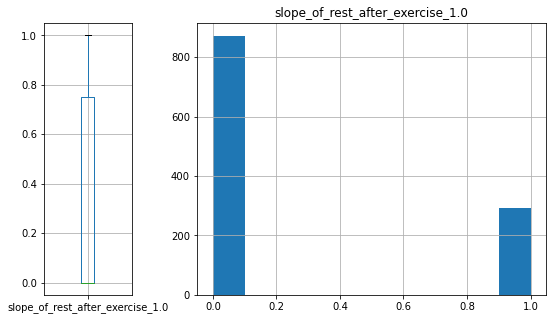

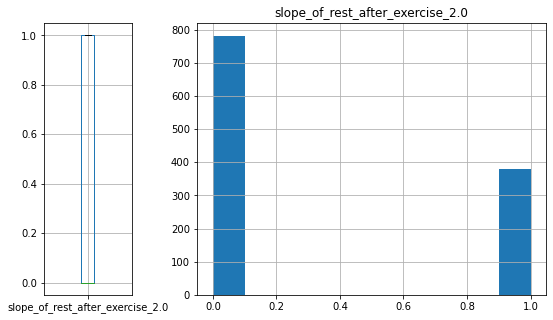

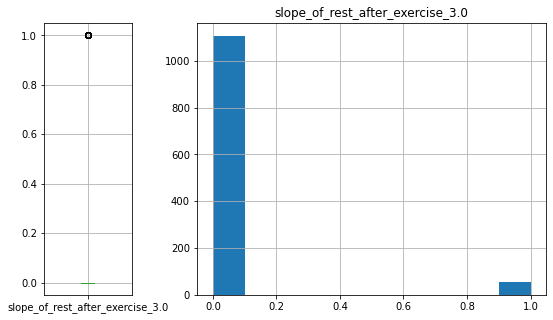

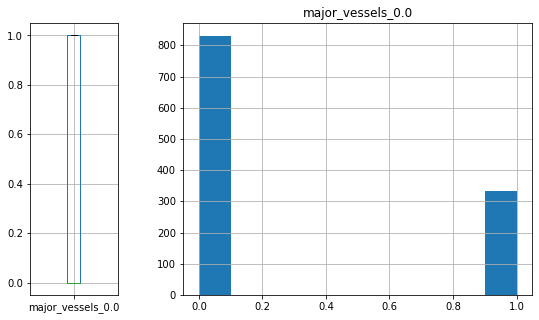

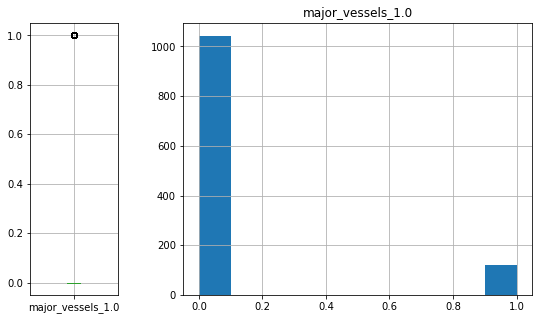

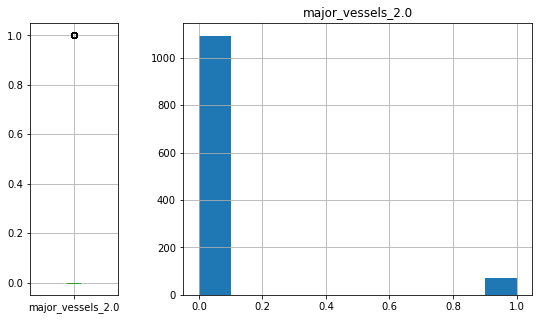

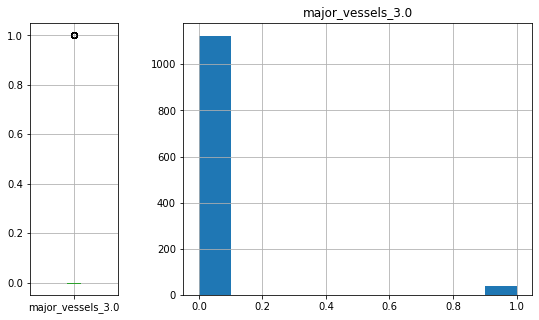

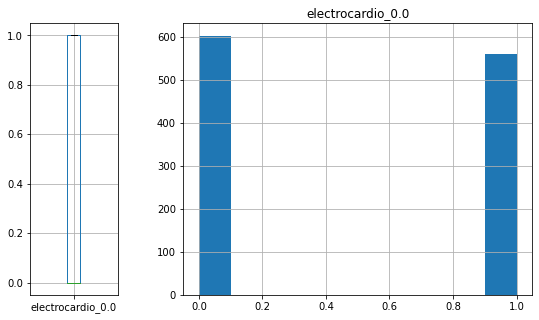

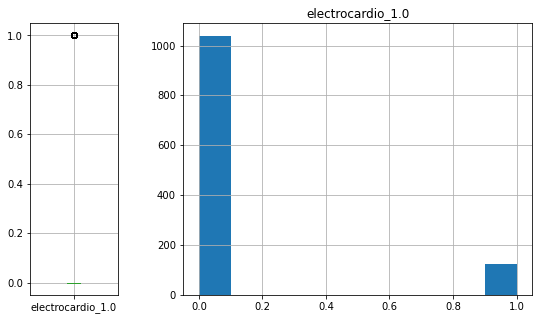

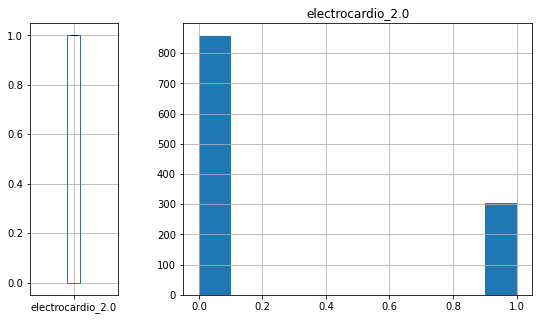

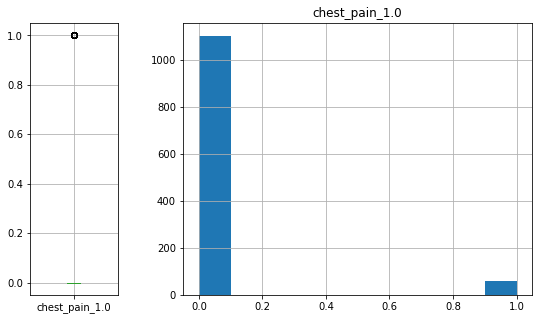

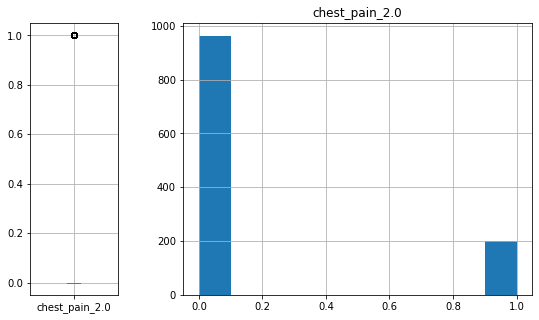

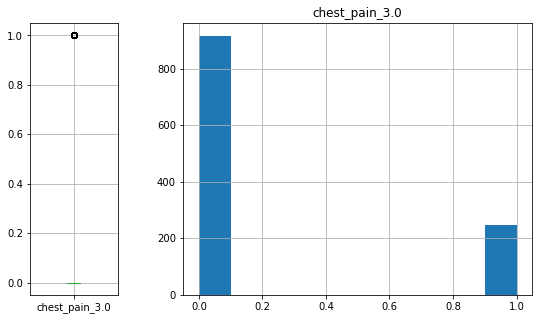

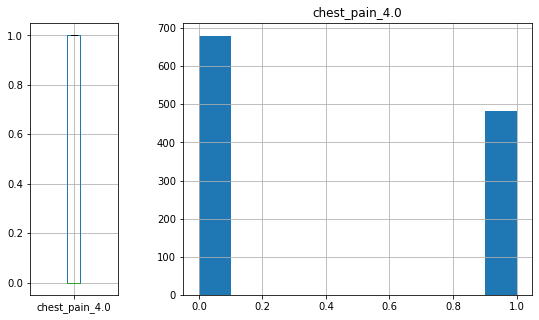

In [101]:
# *------------------------------------------------------*
#                   STATISTICAL ANALYSIS
# *------------------------------------------------------*
hist = df2.hist(bins=50, figsize=(20,20))
box = df2.boxplot()
plt.xticks(rotation='vertical')
plt.xticks(rotation='horizontal')
for name in df2.columns:
    fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
    df2.boxplot(column=name,ax=axes[0])
    df2.hist(column=name, ax=axes[1])
plt.show()

In [102]:
# *------------------------------------------------------*
#                   SAVE PREPROCESING
# *------------------------------------------------------*

df2.to_csv('preprocess.csv', index=False)

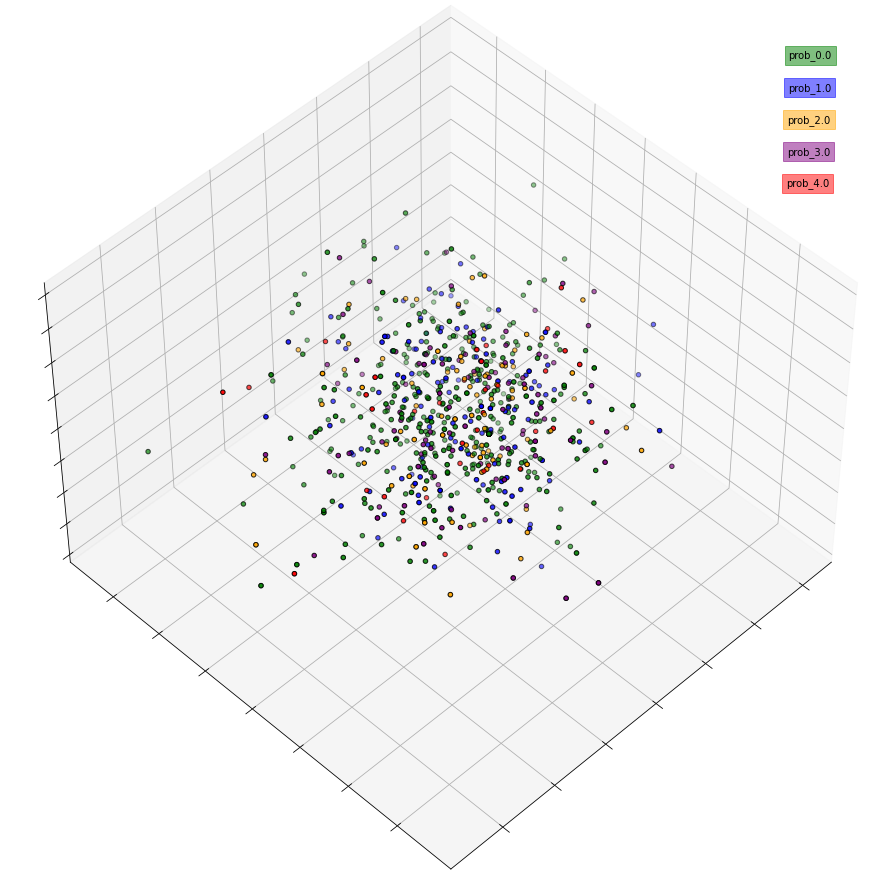

In [103]:
# *------------------------------------------------------*
#                   PCA TO VISUALIZE DATA
# *------------------------------------------------------*

X = df2.drop(columns=['prob'])
y = pd.get_dummies(df2['prob'], prefix='prob')

labels = []

def mapping(Y):
    ret = 0
    for i, value in enumerate(Y):
        ret += i*value
    return int(ret)

for i in range(y.shape[0]):
    labels.append(mapping(y.loc[i,:]))

y['id'] = labels

labels = np.array(labels)


fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 4, 4], elev=48, azim=45)

plt.cla()
pca = decomposition.PCA(n_components=X.shape[1])
pca_vis = decomposition.PCA(n_components=3)
pca_vis.fit(X)
pca.fit(X)
X_vis = pca_vis.transform(X)

colors = ['green', 'blue', 'orange', 'purple',  'red']

for name, label in [('prob_0.0', 0), ('prob_1.0', 1), ('prob_2.0', 2), ('prob_3.0', 3), ('prob_4.0', 4)]:
    ax.text3D(0,
              150 + 0.75*label,
              320 - 15*(label), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor=colors[label], facecolor=colors[label]))
# Reorder the labels to have colors matching the cluster results
y2 = np.choose(y['id'], colors)
ax.scatter(X_vis[:, 0], X_vis[:, 1], X_vis[:, 2], c=y2, cmap=plt.cm.nipy_spectral,
           edgecolor='k')


ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

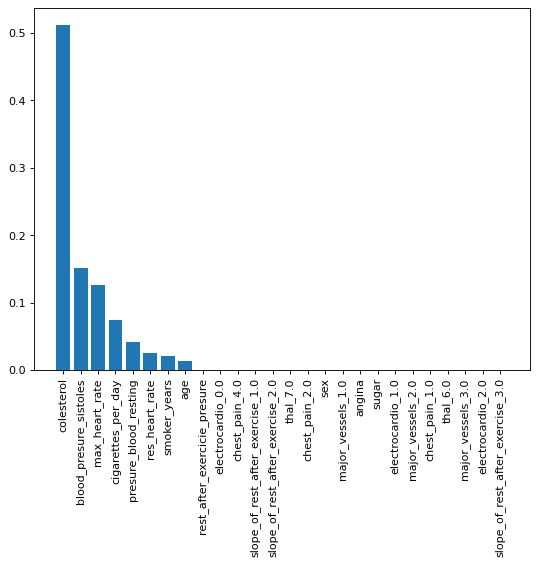

In [104]:
# *------------------------------------------------------*
#          FEATURE IMPORTANCE FOR ALL THE DATASET
# *------------------------------------------------------*

eigenvalues = sorted(list(pca.explained_variance_ratio_), reverse=True)
n_pcs= pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = X.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(most_important_names, eigenvalues)
plt.xticks(rotation='vertical')
plt.show()

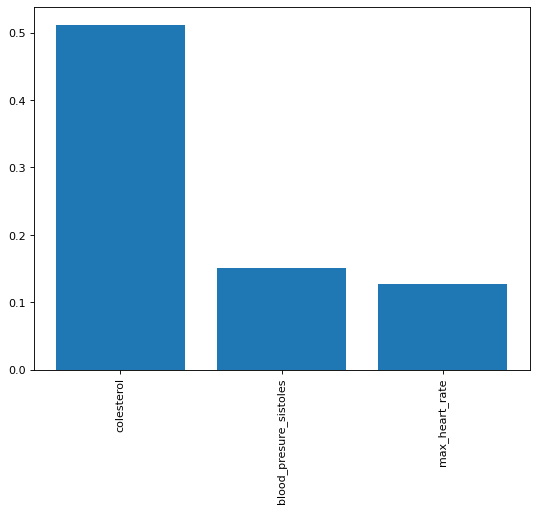

In [105]:
# *------------------------------------------------------*
#          FEATURE IMPORTANCE FOR 3 DIMENSIONS PLOT
# *------------------------------------------------------*


eigenvalues = sorted(list(pca_vis.explained_variance_ratio_), reverse=True)
n_pcs= pca_vis.components_.shape[0]
most_important = [np.abs(pca_vis.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = X.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(most_important_names, eigenvalues)
plt.xticks(rotation='vertical')
plt.show()

In [106]:
# *------------------------------------------------------*
#                       UTILITIES
# *------------------------------------------------------*


'''
# *------------------------------------------------------*
#           DIFFERENCES BETWEEN TWO DATAFRAMES
# *------------------------------------------------------*
ne_stacked = (df3 != df2).stack()
changed = ne_stacked[ne_stacked]
changed.index.names = ['id', 'col']

difference_locations = np.where(df3 != df2)
changed_from = df3.values[difference_locations]
changed_to = df2.values[difference_locations]
a = pd.DataFrame({'from': changed_from, 'to': changed_to}, index=changed.index)
'''


'''
# *------------------------------------------------------*
#           OUTLIERS AFTER IMPUTATION
# *------------------------------------------------------*
col = ['age', 'sex', 'presure_blood_resting', 'colesterol',
       'cigarettes_per_day', 'smoker_years', 'max_heart_rate',
       'res_heart_rate', 'blood_presure_sistoles', 'blood_presure_diastoles']

for name in col:
    df2 = df2[~(np.abs(df2[name] - df2[name].mean()) > 3*df2[name].std())]  
'''

"\n# *------------------------------------------------------*\n#           OUTLIERS AFTER IMPUTATION\n# *------------------------------------------------------*\ncol = ['age', 'sex', 'presure_blood_resting', 'colesterol',\n       'cigarettes_per_day', 'smoker_years', 'max_heart_rate',\n       'res_heart_rate', 'blood_presure_sistoles', 'blood_presure_diastoles']\n\nfor name in col:\n    df2 = df2[~(np.abs(df2[name] - df2[name].mean()) > 3*df2[name].std())]  \n"